# Автоматическая модель определения глазных заболеваний на основе анализа снимков глазного дна технологиями ИИ для автоматической системы скрининга патологий глаза человека

Импорт зависимостей

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

Загрузка датасета с GDrive

In [ ]:
!gdown --id 1Hloj7IZjIs44M_X9unaJWj9ddrAXPZwy

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Hloj7IZjIs44M_X9unaJWj9ddrAXPZwy
From (redirected): https://drive.google.com/uc?id=1Hloj7IZjIs44M_X9unaJWj9ddrAXPZwy&confirm=t&uuid=e21c8434-e54d-4848-8a9f-5aa131f87807
To: /content/eye_diseases.zip
100% 771M/771M [00:30<00:00, 25.6MB/s]


Установка дополнительной зависимости

In [ ]:
!pip install split_folders

Распаковка архива

In [ ]:
!unzip -n eye_diseases.zip

Archive:  eye_diseases.zip


In [ ]:
# Делим на train, val и test
import splitfolders

input_folder = "/content/dataset" # Ввод
output = "/content/ready_dataset" # Вывод

splitfolders.ratio(input_folder, output=output, seed=432, ratio=(0.8, 0.1, 0.1))

Copying files: 4217 files [00:03, 1355.58 files/s]


In [ ]:
batch_size = 64
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='ready_dataset/train', # путь к папке с обучающими данными
  label_mode = 'int',       # представление правильных ответов картинок в виде чисел (Label Encoding): 0, 1, 2, 3...
  color_mode='rgb',         # представление каждой картинки в RGB формате
  batch_size=batch_size,    # параметр, с помощью которого можно регулировать порцию подаваемых примеров (картинок) для сети за одну итерацию обучения
  seed=123,
  image_size=(img_height, img_width), # нейронная сеть всегда принимает изображение определённого размера. Поэтому необходимо предварительно поменять размер каждого изображения
  shuffle=True)                       # перетасовка данных, чтобы генерировать данные не в определённом порядке (сначала 1 класс, потом 2 класс), а случайным образом

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='ready_dataset/val',  # путь к папке с валидационный данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Для тестовых и валидационных данных обычно не рекомендуется включать shuffle (перемешивание). Важно сохранить порядок этих данных, чтобы избежать внесения случайных изменений в процесс оценки модели.

test_ds = tf.keras.utils.image_dataset_from_directory(
  directory='ready_dataset/test',  # путь к папке с тестовыми данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False)

Found 3372 files belonging to 4 classes.
Found 419 files belonging to 4 classes.
Found 426 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names # список классов
num_classes = len(class_names) # количество классов, чтобы указать их в последнем выходном слое

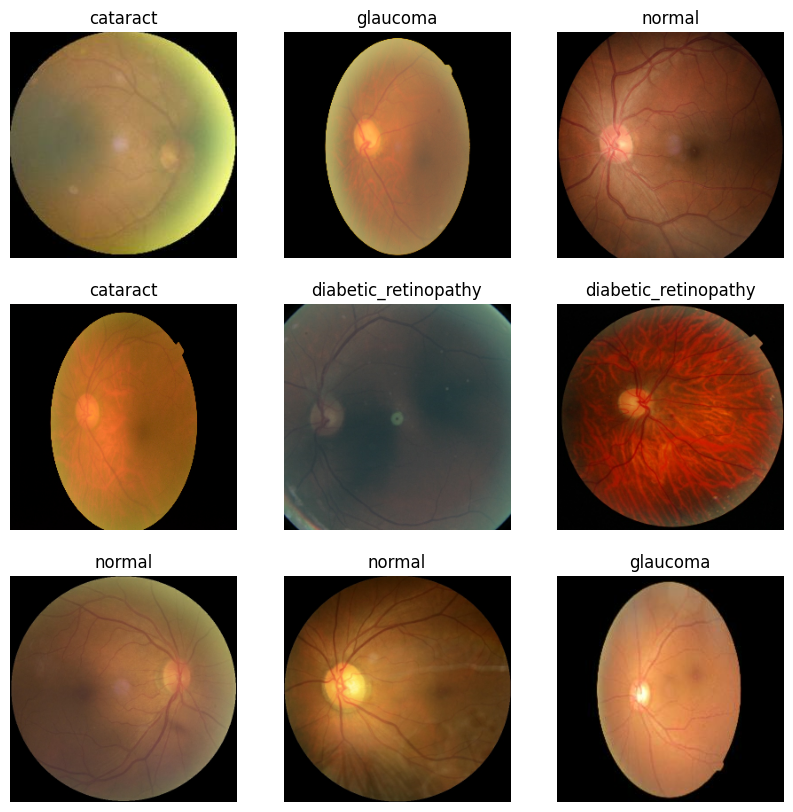

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def createModel(input_shape):
    # Входной слой
    input_layer = Input(shape=input_shape)

    # Нормализация данных от 0 до 1
    normalized_layer = Rescaling(1./255)(input_layer)

    # 1 блок свёртки
    conv_1 = Conv2D(filters=40, kernel_size=(3, 3), activation='relu', padding='same') (normalized_layer)
    pool_1 = MaxPooling2D(2, 2) (conv_1)

    # 2 блок свёртки
    conv_2 = Conv2D(50, (3, 3), activation='relu', padding='same') (pool_1)
    drop_2 = Dropout(0.2) (conv_2)

    # 3 блок свёртки
    conv_3 = Conv2D(60, (3, 3), activation='relu', padding='same') (drop_2)
    pool_3 = MaxPooling2D(2, 2) (conv_3)
    drop_3 = Dropout(0.1) (pool_3)

    conv_4 = Conv2D(70, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-4)) (drop_3)
    pool_4 = MaxPooling2D(2, 2) (conv_4)

    averaged_features = GlobalAveragePooling2D()(pool_4)
    flatten_features = Flatten() (averaged_features)
    output = Dense(num_classes, activation='softmax') (flatten_features)

    return Model(inputs=input_layer, outputs=output)

In [ ]:
def compileModel():
    model = createModel((img_height, img_width, 3))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    model.summary()
    return model

In [ ]:
model = compileModel()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 40)        │           1,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 40)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 50)        │          18,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128, 128, 50)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 60)        │          27,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 62, 62, 70)          │          37,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 70)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 70)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             284 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,384 (329.62 KB)

 Trainable params: 84,384 (329.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
save_callback = ModelCheckpoint(filepath='best_model.keras',
                                monitor = 'val_loss',
                                save_best_only = True,
                                save_weights_only=False,
                                mode = 'min',
                                verbose=1)

In [ ]:
model.fit(train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=[save_callback]
        )

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.5798 - sparse_categorical_accuracy: 0.7705
Epoch 1: val_loss improved from inf to 0.60792, saving model to best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 351ms/step - loss: 0.5802 - sparse_categorical_accuracy: 0.7703 - val_loss: 0.6079 - val_sparse_categorical_accuracy: 0.7088
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - loss: 0.5964 - sparse_categorical_accuracy: 0.7508
Epoch 2: val_loss improved from 0.60792 to 0.57699, saving model to best_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 391ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.5770 - val_sparse_categorical_accuracy: 0.7399
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7653
Epoch 3: val_loss did not improve from 0.57699
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 370ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.5983 - val_sparse_categorical_accuracy: 0.7518
Epoc

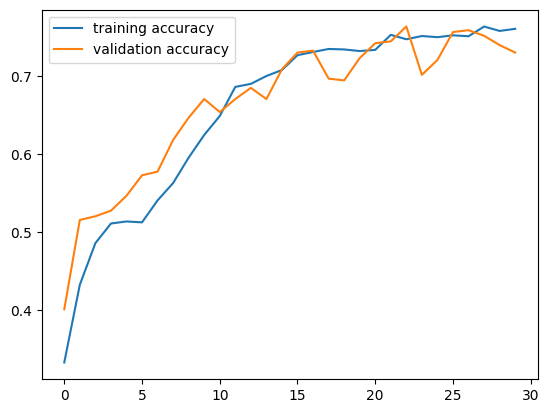

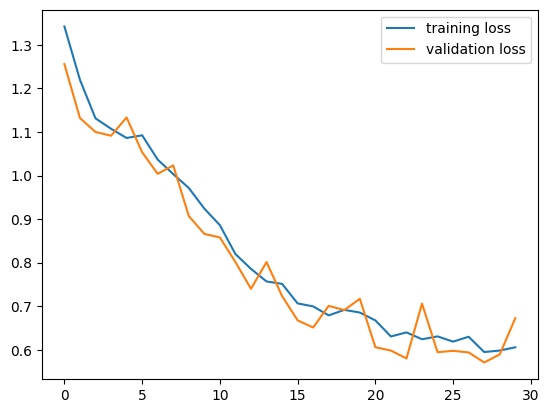

In [ ]:
# Вывод графиков обучения

plt.figure()
plt.plot(model.history.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(model.history.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [ ]:
# Загрузка весов самой лучшей модели с самой малеьнокй ошибкой
model.load_weights('best_model.weights.h5')

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0

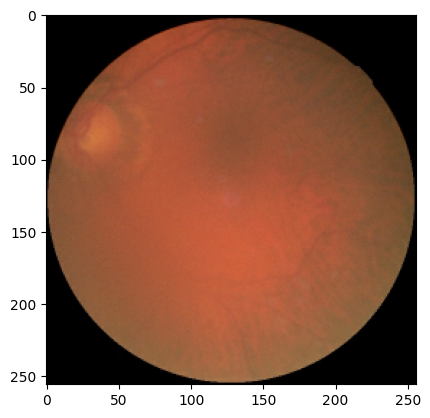

In [ ]:
# Здесь мы берём каждый раз случайное изображение из test_ds и предсказываем для него класс.
# Эту ячейку можно запускать много раз и смотреть результаты классификации для разных картинок.
for image_batch, label_batch in test_ds.shuffle(buffer_size=10).take(1):
    image = image_batch[1]
    label = label_batch[1]
    predictions = model.predict(tf.expand_dims(image, axis=0))
    # Get the predicted class label
    predicted_class_index = tf.argmax(predictions, axis=-1)
    predicted_class_label = test_ds.class_names[predicted_class_index[0]]
    # Print the predicted class label and true label
    print("Предсказанный ответ:", predicted_class_label)
    print("Правильный ответ:", test_ds.class_names[label])
    plt.imshow(image.numpy().astype("uint8"))

In [ ]:
# Эту ячейку вы можете использовать для рассчёта точности по каждому классу.

from sklearn.metrics import accuracy_score
import numpy as np

y_pred = model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Get unique classes
classes = list(set(true_labels))

# Print accuracy for each class
print("Accuracy by Class:")
for cls in classes:
    cls_true = [true_labels[i] for i in range(len(true_labels)) if predicted_labels[i] == cls]
    cls_pred = [predicted_labels[i] for i in range(len(predicted_labels)) if predicted_labels[i] == cls]
    cls_accuracy = accuracy_score(cls_true, cls_pred)
    print(f"Class {test_ds.class_names[cls]}: {cls_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 849ms/step
Accuracy by Class:
Class cataract: 0.8235294117647058
Class diabetic_retinopathy: 0.9727272727272728
Class glaucoma: 0.65
Class normal: 0.7094594594594594


In [ ]:
# Если нужно использовать ранее обученную  модель


model = createModel((img_height, img_width, 3))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')


model.load_weights('best_model_weights.h5')